In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice

%load_ext autoreload
%matplotlib inline

## Visualize Moire Potential

<a list of 90 text.Text objects>

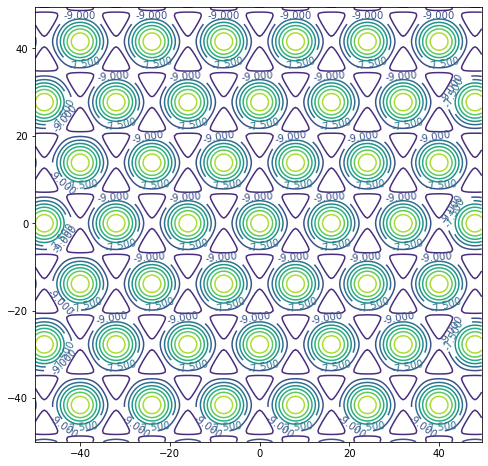

In [2]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

## Parameterize random walkers

In [3]:
%autoreload 2
from walker import Graphene_Walker
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1meV energy amplitude
walkers = Graphene_Walker(0.246, 15) # 2.46 Angstrom lattice, 10 Kelvin
tracks = walkers.get_tracks(moire, nsteps=300, njumps=100000, nparticles=100)

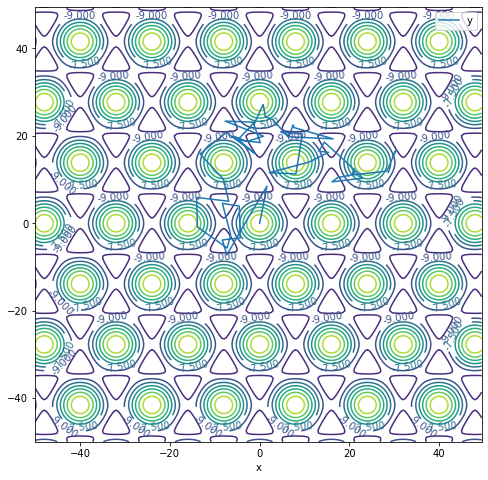

In [4]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
tracks[tracks['particle'] == 0].plot(x = 'x', y='y', ax=ax)

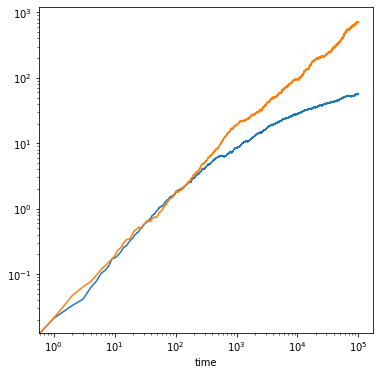

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for temperature in [2, 10]:
    moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    tracks = walkers.get_tracks(moire, nsteps=100000, njumps=100000, nparticles=100, endT=1e5)
    tracks.groupby('time')['r^2'].mean().plot(ax=ax)
    x = np.linspace(1, tracks.time.max())
    ax.set_xscale("log")
    ax.set_yscale("log")